In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modules as mod
import networkx as nx

In [38]:
# Number of market participants 
N = 1600 

# Number of fundamentalists and chartists
N_FUND = 800
N_CHART = 800

# Initial price of the asset traded
P_0 = 100

# Global fundamental price 
P_F = 120

# Variation around the global fundamental price 
THETA = 30

# Maximum extension for chartists' timesteps window 
T_MAX = 15

# Sensitivity of forecasts for fundamentalists
PHI = 2.0

# Sensitivity of forecasts for chartists 
KAPPA = 2.0

# level of information dissipation among the agents
ALPHA = 0.95

# Weight of the market imbalance
DELTA = 0.05

# Intervals of variation for the stochastic noise term 
SIGMA = 30

# Sensitivity threshold for choosing the status
TAO = 20

# Asset quantity for each trader
Q = 50

# Initializing traders' wealth (W), money (M), and asset quantity(Q)
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)] 

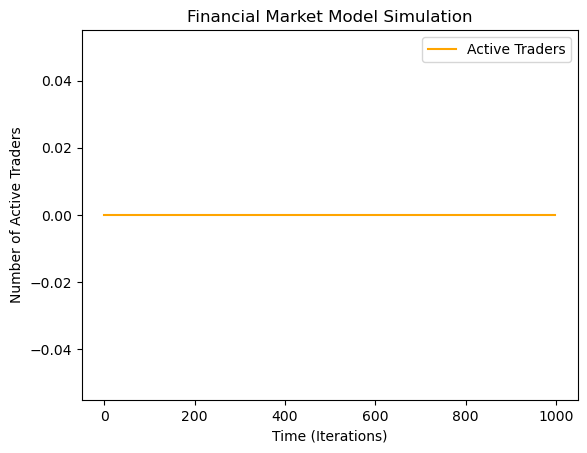

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D square lattice with open boundary conditions and an average degree <k>=4
size = int(np.sqrt(1600))  # Assuming N=1600, create a size*size network
Network_SW = nx.grid_2d_graph(size, size, periodic=False)

# Convert the 2D nodes into a list of indices for easy selection
nodes_indices = list(range(len(flat_nodes)))

# Add the edges to the network to mimic a Small World network
rewiring_prob = 0.02  # Probability for rewiring each edge
for edge in list(Network_SW.edges()):
    if np.random.rand() < rewiring_prob:
        Network_SW.remove_edge(*edge)
        # Randomly choose two new indices from the list of indices
        new_index1, new_index2 = np.random.choice(nodes_indices, 2, replace=False)
        # Map indices back to the actual node tuples
        new_edge = (flat_nodes[new_index1], flat_nodes[new_index2])
        # Add the new edge to the network if it doesn't create a self-loop or duplicate edge
        if new_edge[0] != new_edge[1] and not Network_SW.has_edge(*new_edge):
            Network_SW.add_edge(*new_edge)

# Initialize the information level Ii(t) for each agent
Ith = 1.0  # Threshold for all agents
informations = {node: np.random.uniform(0, Ith) for node in Network_SW.nodes()}

# Initialize the status of each trader (asker, bidder, holder)
statuses = {node: np.random.choice(['asker', 'bidder', 'holder']) for node in Network_SW.nodes()}

# Simulation parameters
alpha = 0.95  # Dissipation level of information
delta_I = 0.1  # Max increase of information at each time step
time_steps = 1000  # Number of time steps in the simulation

# Simulation execution loop
for t in range(time_steps):
    # Global informative pressure
    for node in Network_SW.nodes():
        informations[node] += np.random.uniform(0, max(0, Ith - informations[node]))

    # Herding mechanism
    for node in Network_SW.nodes():
        if informations[node] > Ith:
            statuses[node] = 'active'  # The trader becomes active
            informations[node] = 0  # Reset information
            neighbors = list(Network_SW.neighbors(node))
            # Spread the information to the neighbors
            for nn in neighbors:
                informations[nn] += alpha * informations[node] / len(neighbors)
                if informations[nn] > Ith and statuses[nn] != 'active':
                    statuses[nn] = 'active'  # Neighbor becomes active too

# Plotting
# For simplicity, let's just plot the number of active traders over time
active_counts = []
for t in range(time_steps):
    active_count = sum(status == 'active' for status in statuses.values())
    active_counts.append(active_count)
    # Reset the status for the next iteration
    for node in statuses:
        if statuses[node] == 'active':
            statuses[node] = np.random.choice(['asker', 'bidder', 'holder'])

plt.plot(active_counts, label='Active Traders', color='orange')
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Active Traders')
plt.legend()
plt.title('Financial Market Model Simulation')
plt.show()


In [ ]:
# 创建小世界网络
network = nx.watts_strogatz_graph(N, 4, 0.1)
Ith = 1.0
# 初始化代理人属性
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('threshold', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = ('fund' if i < N_FUND else 'chart', W[i], M, Q, np.random.uniform(0, TAO), 'hold', np.random.uniform(0, Ith))

# 在模拟开始前初始化一个列表来存储每个时间步的活跃交易者数量
active_traders = []

# 模拟市场动态
for t in range(1, 100):  # 假设模拟100个时间步
    # 更新代理人状态和交易决策
    for i, agent in enumerate(agents):
        # 增加信息资产
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))

        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            agent['decision'] = np.random.choice(['buy', 'sell', 'hold'])
        else:  # 'chart'
            # Chartist agents buy if price is increasing, sell if decreasing
            agent['decision'] = np.random.choice(['buy', 'sell', 'hold'])

    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
        # Share decision information with neighbors
        for neighbor in neighbors:
            agents[neighbor]['decision'] = agent['decision']

            # 如果邻居的信息资产超过阈值，那么他们也变得活跃，并模仿决策
            if agents[neighbor]['info'] > Ith:
                agents[neighbor]['decision'] = agent['decision']

    # 计算活跃交易者数量（即决定买入或卖出的交易者数量）
    active_traders_count = sum(agent['decision'] in ['buy', 'sell'] for agent in agents)
    active_traders.append(active_traders_count)

# 在模拟结束后，创建一个图表来显示活跃交易者数量随时间的变化
plt.figure(figsize=(10, 6))
plt.plot(range(1, 100), active_traders, marker='o')
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Active Traders')
plt.title('Number of Active Traders Over Time')
plt.grid(True)
plt.show()

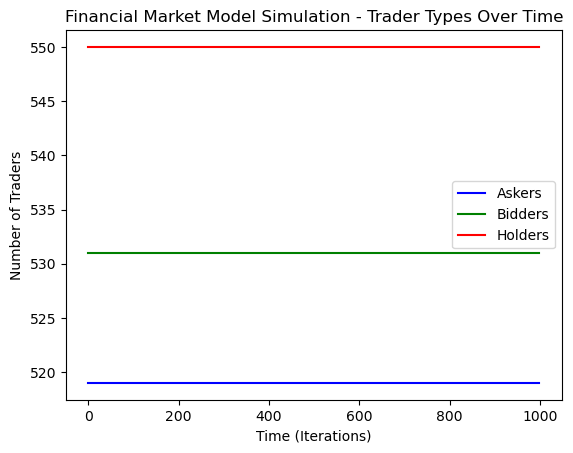

In [10]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D square lattice with open boundary conditions and an average degree <k>=4
size = int(np.sqrt(1600))  # Assuming N=1600, create a size*size network
Network_SW = nx.grid_2d_graph(size, size, periodic=False)

## Convert the 2D nodes into a list of indices for easy selection
nodes_indices = list(range(len(flat_nodes)))

# Add the edges to the network to mimic a Small World network
rewiring_prob = 0.02  # Probability for rewiring each edge
for edge in list(Network_SW.edges()):
    if np.random.rand() < rewiring_prob:
        Network_SW.remove_edge(*edge)
        # Randomly choose two new indices from the list of indices
        new_index1, new_index2 = np.random.choice(nodes_indices, 2, replace=False)
        # Map indices back to the actual node tuples
        new_edge = (flat_nodes[new_index1], flat_nodes[new_index2])
        # Add the new edge to the network if it doesn't create a self-loop or duplicate edge
        if new_edge[0] != new_edge[1] and not Network_SW.has_edge(*new_edge):
            Network_SW.add_edge(*new_edge)

# Initialize the information level Ii(t) for each agent
Ith = 1.0  # Threshold for all agents
informations = {node: np.random.uniform(0, Ith) for node in Network_SW.nodes()}

# Initialize the status of each trader (asker, bidder, holder)
statuses = {node: np.random.choice(['asker', 'bidder', 'holder']) for node in Network_SW.nodes()}

# Simulation parameters
alpha = 0.95  # Dissipation level of information
delta_I = 0.1  # Max increase of information at each time step
time_steps = 1000  # Number of time steps in the simulation

# Keep track of the number of 'asker', 'bidder', and 'holder' over time
asker_counts, bidder_counts, holder_counts = [], [], []

# Simulation execution loop
for t in range(time_steps):
    # Apply the global informative pressure and check if any trader exceeds the threshold
    for node in Network_SW.nodes():
        informations[node] += np.random.uniform(0, max(0, Ith - informations[node]))
        if informations[node] > Ith:
            # The trader becomes active and we record its current status
            active_status = statuses[node]
            informations[node] = 0  # Reset information
            # Spread the information to the neighbors
            neighbors = list(Network_SW.neighbors(node))
            for nn in neighbors:
                informations[nn] += alpha * informations[node] / len(neighbors)
                # If a neighbor exceeds the threshold, they adopt the status of the active trader
                if informations[nn] > Ith:
                    statuses[nn] = active_status
                    informations[nn] = 0  # Reset information after becoming active

    # Count the number of each type of trader after updates
    asker_count = sum(status == 'asker' for status in statuses.values())
    bidder_count = sum(status == 'bidder' for status in statuses.values())
    holder_count = sum(status == 'holder' for status in statuses.values())

    asker_counts.append(asker_count)
    bidder_counts.append(bidder_count)
    holder_counts.append(holder_count)

# Plotting
plt.plot(asker_counts, label='Askers', color='blue')
plt.plot(bidder_counts, label='Bidders', color='green')
plt.plot(holder_counts, label='Holders', color='red')
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Traders')
plt.legend()
plt.title('Financial Market Model Simulation - Trader Types Over Time')
plt.show()


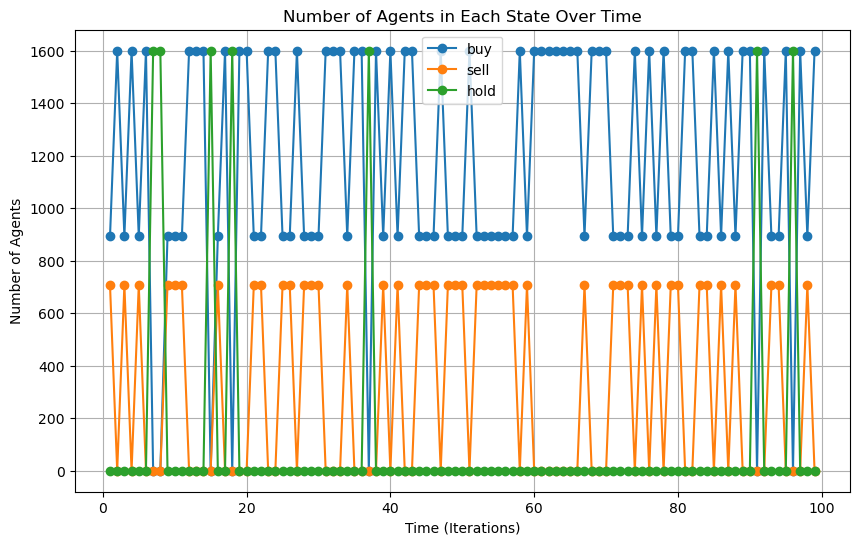

In [20]:
low_price = 10
high_price = 100
price_change_threshold = 0.05  # Price change threshold for holding

# Create a small-world network
network = nx.watts_strogatz_graph(N, 4, 0.02)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('threshold', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(0, TAO), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Initialize expected and actual price
expected_price = np.random.uniform(low_price, high_price)
actual_price = np.random.uniform(low_price, high_price)

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}

# Simulate market dynamics
for t in range(1, 100):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))

        # Calculate price change
        price_change = abs(actual_price - expected_price) / expected_price

        if price_change < price_change_threshold:
            # If price change is within the threshold, hold
            agent['decision'] = 'hold'
        else:
            if agent['type'] == 'fund':
                # Fundamentalist agents buy if price is lower than expected price, sell if higher
                agent['decision'] = 'buy' if actual_price < expected_price else 'sell'
            else:  # 'chart'
                # Chartist agents buy if price is increasing, sell if decreasing
                agent['decision'] = 'buy' if actual_price > agent['info'] else 'sell'

    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
        # Share decision information with neighbors
        for neighbor in neighbors:
            agents[neighbor]['decision'] = agent['decision']

            # If the neighbor's information assets exceed the threshold, they also become active and imitate the decision
            if agents[neighbor]['info'] > Ith:
                agents[neighbor]['decision'] = agent['decision']

    # Calculate the number of agents in each state
    for state in ['buy', 'sell', 'hold']:
        state_counts[state].append(sum(agent['decision'] == state for agent in agents))

    # Update expected and actual price for the next time step
    expected_price = np.random.uniform(low_price, high_price)
    actual_price = np.random.uniform(low_price, high_price)

# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(1, 100), counts, marker='o', label=state)
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Set actual price
actual_price = 100
TAO = 20
Ith = 1.0

# Create a small-world network
network = nx.watts_strogatz_graph(N, 4, 0.1)
# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8'), ('active', 'bool')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))



# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}

# Simulate market dynamics
for t in range(1, 100):  # Assume 100 time steps for the simulation
    
    # Update trading decisions of fundamentalist based on price
    for i, agent in enumerate(agents):
        if agent['type'] == 'fund':
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
                
    # global informative pressure coming from external sources
    for i, agent in enumerate(agents):
        # Increase the agent's information by a random value
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))
        # Determine if the agent becomes active
        if agent['info'] > Ith and agent['type'] in ['fund', 'chart']:
            agent['active'] = True
            agent['info'] = 0  # Reset info after becoming active
        else:
            agent['active'] = False
            
    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        alpha = 0.95  # Control the level of dissipation of the information
        
        # Check if the agent's information exceeds the threshold
        
        if agent['info'] > Ith:
            # Reset the agent's info after it becomes active
            info_to_share = agent['info']
            agent['info'] = 0  
            
            neighbors = list(network.neighbors(i))
            
            for neighbor in neighbors:
                # Pass a fraction of the active agent's info to the neighbors
                agents[neighbor]['info'] += alpha * info_to_share / len(neighbors)
        
                # Check if the neighbor's information now exceeds the threshold
                if agents[neighbor]['info'] > Ith:
                    # The neighbor adopts the decision of the active agent
                    agents[neighbor]['decision'] = agent['decision']
                    # Reset the neighbor's info as they are now active
                    agents[neighbor]['info'] = 0  

    # Calculate the number of agents in each state
    for state in ['buy', 'sell', 'hold']:
        state_counts[state].append(sum(agent['decision'] == state for agent in agents))

    # Update expected and actual price for the next time step
    expected_price = np.random.uniform(low=50, high=150)
    actual_price = 100

# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(1, 100), counts, marker='o', label=state)
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

ValueError: could not assign tuple of length 7 to structure with 8 fields.

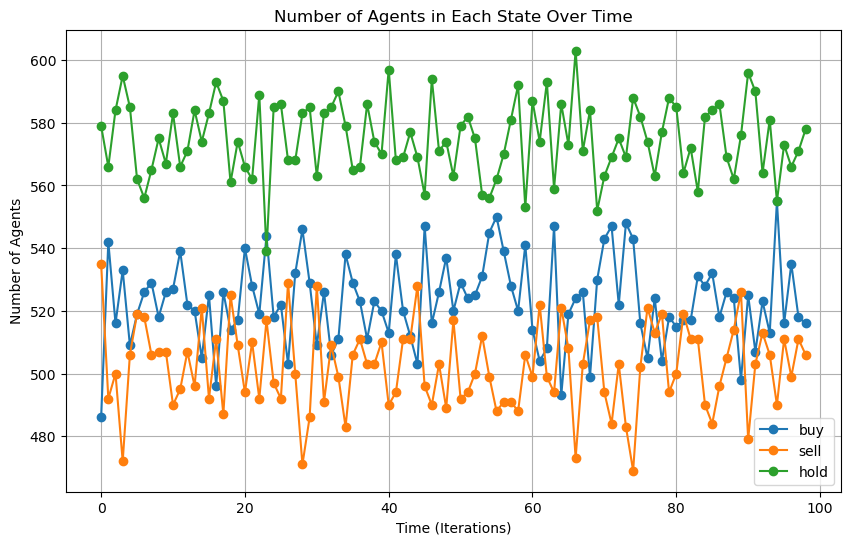

In [61]:
network = nx.watts_strogatz_graph(N, 4, 0.1)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))
    
# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}

actual_price = 100

# Simulate market dynamics
for t in range(1, 100):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))

        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
        else:  # 'chart'
            # Chartist agents buy if price is increasing, sell if decreasing
            agent['decision'] = np.random.choice(['buy', 'sell', 'hold'])

    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
        # Share decision information with neighbors only if agent's information assets exceed Ith
        if agent['info'] > Ith:
            # Counting neighbors
            N_nn = len(neighbors)
            for neighbor in neighbors:
                # Add the agent's information to the neighbor's information assets
                agents[neighbor]['info'] += (ALPHA / N_nn) * agent['info']

                # If the neighbor's information assets exceed the threshold, they also become active and imitate the decision
                if agents[neighbor]['info'] > Ith:
                    agents[neighbor]['decision'] = agent['decision']
            # Reset the agent's information to 0
            agent['info'] = 0

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])

# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, marker='o', label=state)
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

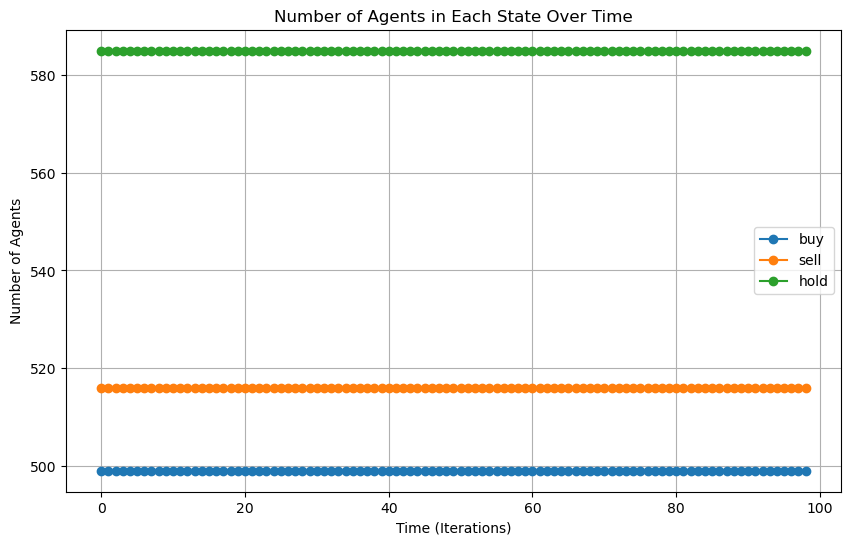

In [34]:
network = nx.watts_strogatz_graph(N, 4, 0.1)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))
    
# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}

actual_price = 100
ALPHA = 0.95

# Simulate market dynamics
for t in range(1, 100):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))

        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'

    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
        # Share decision information with neighbors only if agent's information assets exceed Ith
        if agent['info'] > Ith:
            # Counting neighbors
            N_nn = len(neighbors)
            # Store the agent's info to share with neighbors before resetting
            info_to_share = agent['info']
            agent['info'] = 0  # Reset the agent's information after sharing
            
            for neighbor in neighbors:
                # Add the agent's information to the neighbor's information assets
                agents[neighbor]['info'] += (ALPHA / N_nn) * info_to_share

                # If the neighbor's information assets exceed the threshold, they also become active
                if agents[neighbor]['info'] > Ith:
                    # The neighbor imitates the decision of the active agent
                    agents[neighbor]['decision'] = agent['decision']
                    # The neighbor's info is reset as they have now become active
                    agents[neighbor]['info'] = 0

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])

# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, marker='o', label=state)
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define the constants
N = 1600 
N_FUND = 800
N_CHART = 800
P_0 = 100
P_F = 120
THETA = 30
PHI = 2.0
T_MAX = 15
PHI = 2.0
KAPPA = 2.0
ALPHA = 0.95
DELTA = 0.05
SIGMA = 30
TAO = 20
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)]

Ith = 1.0

low_price = 50
high_price = 150
actual_price = 100

# Define the functions
def receive_global_info(agent, Ith):
    """Receive global informative pressure from external sources."""
    agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))

def receive_individual_info(agent, neighbors, ALPHA, N_nn):
    """Receive individual information pressure from neighbors."""
    info_to_share = agent['info']
#     agent['info'] = 0  # Reset the agent's information after sharing
    for neighbor in neighbors:
        agents[neighbor]['info'] += (ALPHA / N_nn) * info_to_share
        if agents[neighbor]['info'] > Ith:
            agents[neighbor]['decision'] = agent['decision']
#             agents[neighbor]['info'] = 0  # The neighbor becomes active

def adjust_fundamentalist_decision(agent, actual_price, TAO):
    """Adjust the state of 'fund' type agents based on expected and actual price difference."""
    price_difference = agent['expected_price'] - actual_price
    if abs(price_difference) < TAO:
        agent['decision'] = 'hold'
    elif price_difference > TAO and agent['money'] > 0:
        agent['decision'] = 'buy'
    elif price_difference < -TAO and agent['quantity'] > 0:
        agent['decision'] = 'sell'


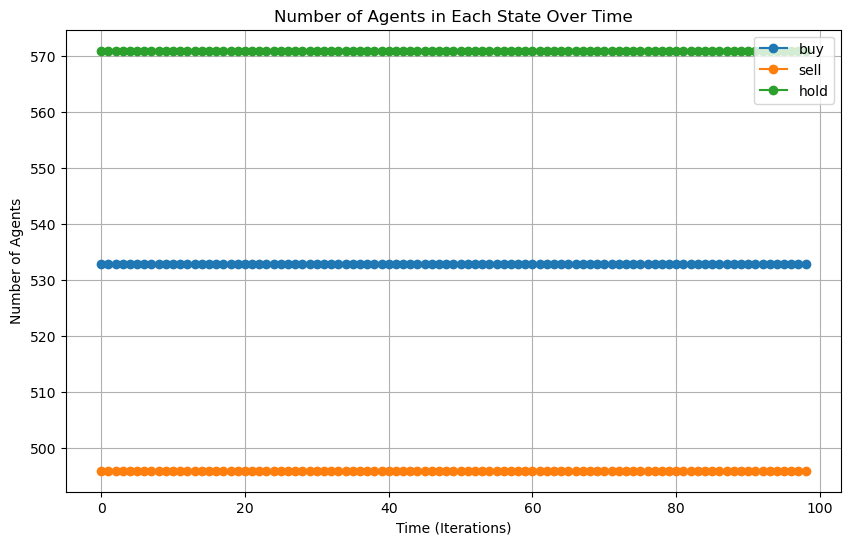

In [39]:
# Initialize agents
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=low_price, high=high_price), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Simulation
network = nx.watts_strogatz_graph(N, 4, 0.1)
state_counts = {'buy': [], 'sell': [], 'hold': []}

for t in range(1, 100):  # Time steps
    for i, agent in enumerate(agents):
        receive_global_info(agent, Ith)
        if agent['type'] == 'fund':
            adjust_fundamentalist_decision(agent, actual_price, TAO)

    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
        N_nn = len(neighbors)
        if agent['info'] > Ith:
            receive_individual_info(agent, neighbors, ALPHA, N_nn)

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])

# Plotting
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, marker='o', label=state)
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define the constants
N = 1600 
N_FUND = 800
N_CHART = 800
P_0 = 100
P_F = 120
THETA = 30
PHI = 2.0
T_MAX = 15
PHI = 2.0
KAPPA = 2.0
ALPHA = 0.95
DELTA = 0.05
SIGMA = 30
TAO = 20
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)]

Ith = 1.0

low_price = 50
high_price = 150
actual_price = 100

# Define the functions
def receive_global_info(agent, Ith):
    """Receive global informative pressure from external sources."""
    agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))

def spread_information(i, agents, network, ALPHA, Ith, already_active=None):
    """Spread information from active agents to their neighbors recursively."""

    neighbors = list(network.neighbors(i))
    N_nn = len(neighbors)
    agent_info = agents[i]['info']

    if agent_info > Ith and i not in already_active:
        already_active.add(i)
        agents[i]['info'] = 0  # Reset the agent's information after sharing

        for neighbor in neighbors:
            agents[neighbor]['info'] += (ALPHA / N_nn) * agent_info
            if agents[neighbor]['info'] > Ith:
                agents[neighbor]['decision'] = agents[i]['decision']
                spread_information(neighbor, agents, network, ALPHA, Ith, already_active)


def adjust_fundamentalist_decision(agent, actual_price, TAO):
    """Adjust the state of 'fund' type agents based on expected and actual price difference."""
    price_difference = agent['expected_price'] - actual_price
    if abs(price_difference) < TAO:
        agent['decision'] = 'hold'
    elif price_difference > TAO and agent['money'] > 0:
        agent['decision'] = 'buy'
    elif price_difference < -TAO and agent['quantity'] > 0:
        agent['decision'] = 'sell'


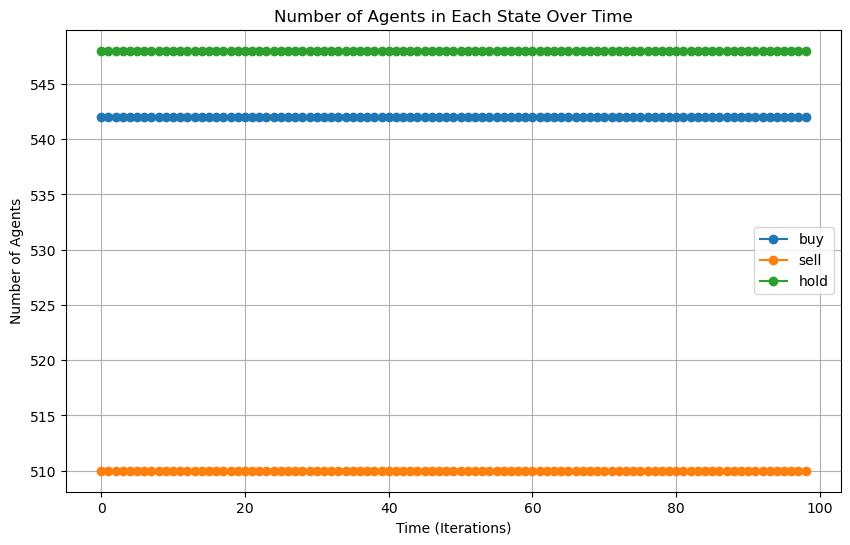

In [53]:
# Initialize agents
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=low_price, high=high_price), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Simulation
network = nx.watts_strogatz_graph(N, 4, 0.1)
state_counts = {'buy': [], 'sell': [], 'hold': []}

for t in range(1, 100):  # Time steps
    already_active = set()  # Create the set of already active agents for this time step

    for i, agent in enumerate(agents):
        receive_global_info(agent, Ith)

    for i, agent in enumerate(agents):
        # Start a new cascade if this agent is active
        if agent['info'] > Ith:
            spread_information(i, agents, network, ALPHA, Ith, already_active)

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])

# Plotting
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, marker='o', label=state)
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

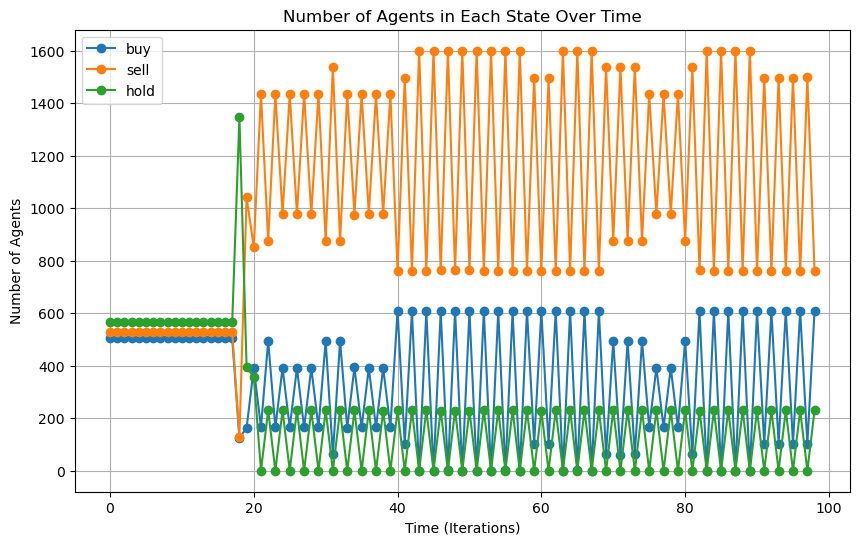

In [10]:
network = nx.watts_strogatz_graph(N, 4, 0.1)
Ith = 1.0
# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))
    
# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}

actual_price = 100

# Simulate market dynamics
for t in range(1, 100):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))

        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'


    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
        # Share decision information with neighbors only if agent's information assets exceed Ith
        if agent['info'] >= Ith:
            # Counting neighbors
            N_nn = len(neighbors)
            for neighbor in neighbors:
                # Add the agent's information to the neighbor's information assets
                agents[neighbor]['info'] += (ALPHA / N_nn) * agent['info']

                # If the neighbor's information assets exceed the threshold, they also become active and imitate the decision
                if agents[neighbor]['info'] >= Ith:
                    agents[neighbor]['decision'] = agent['decision']
            # Reset the agent's information to 0
            agent['info'] = 0
#     for i, agent in enumerate(agents):
#         print(agent['info'])

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])

# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, marker='o', label=state)
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

/var/folders/w0/fxhkhvr96td2sb6vcsy_mbtr0000gn/T/ipykernel_59470/2010950373.py:58: RuntimeWarning: overflow encountered in scalar add
  agents[nn]['info'] += (ALPHA / N_nn_nn) * agents[neighbor]['info']
/var/folders/w0/fxhkhvr96td2sb6vcsy_mbtr0000gn/T/ipykernel_59470/2010950373.py:47: RuntimeWarning: overflow encountered in scalar add
  agents[neighbor]['info'] += (ALPHA / N_nn) * agent['info']


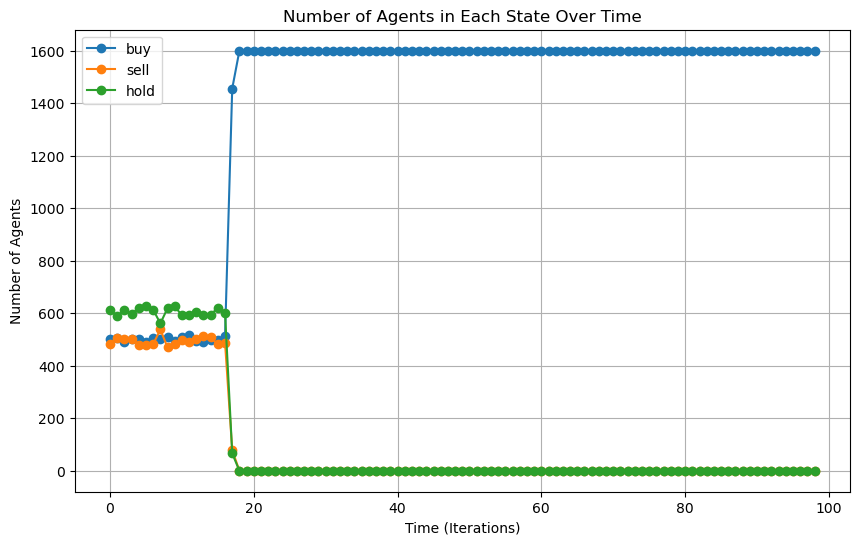

In [14]:
# Create network
network = nx.watts_strogatz_graph(N, 4, 0.02)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}

actual_price = 100

# Simulate market dynamics
for t in range(1, 100):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))

        
        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
        else:  # 'chart'
            # Chartist agents buy if price is increasing, sell if decreasing
            agent['decision'] = np.random.choice(['buy', 'sell', 'hold'])

    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
    # Share decision information with neighbors only if agent's information assets exceed Ith
        if agent['info'] >= Ith:
        # Counting neighbors
            N_nn = len(neighbors)
            for neighbor in neighbors:
            # Add the agent's information to the neighbor's information assets
                agents[neighbor]['info'] += (ALPHA / N_nn) * agent['info']
            # Check if the information assets exceed the maximum value
                agents[neighbor]['info'] = min(agents[neighbor]['info'], np.finfo(float).max)

            # If the neighbor's information assets exceed the threshold, they also become active and imitate the decision
                if agents[neighbor]['info'] >= Ith:
                    agents[neighbor]['decision'] = agent['decision']
                # Neighbor also shares the decision with its neighbors
                    neighbor_neighbors = list(network.neighbors(neighbor))
                    N_nn_nn = len(neighbor_neighbors)
                    for nn in neighbor_neighbors:
                        agents[nn]['info'] += (ALPHA / N_nn_nn) * agents[neighbor]['info']
                    # Check if the information assets exceed the maximum value
                        agents[nn]['info'] = min(agents[nn]['info'], np.finfo(float).max)
                        if agents[nn]['info'] >= Ith:
                            agents[nn]['decision'] = agents[neighbor]['decision']
        # Reset the agent's information to 0
            agent['info'] = 0

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])

# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, marker='o', label=state)
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

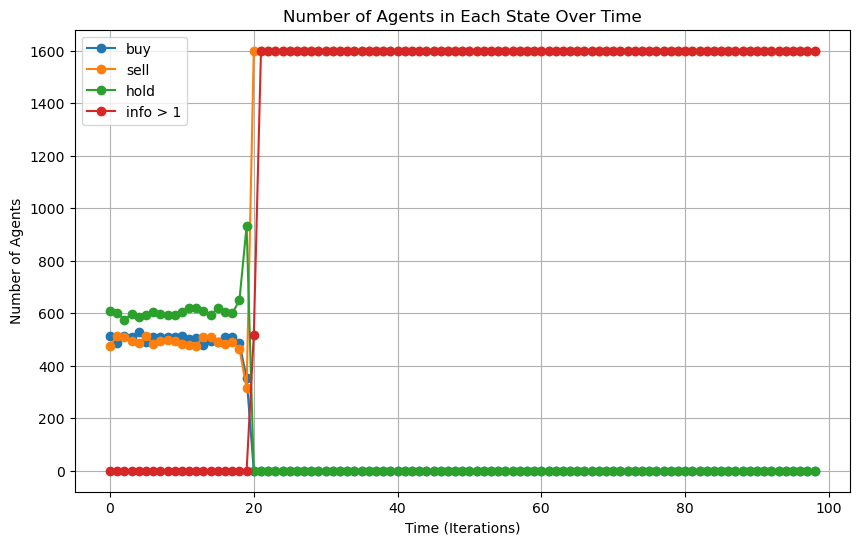

In [28]:
# Create network
network = nx.watts_strogatz_graph(N, 4, 0.02)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}
info_counts = []  # List to store the count of agents with info > 1 at each time step

actual_price = 100
ALPHA = 0.5

# Simulate market dynamics
for t in range(1, 100):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    info_count = 0  # Counter for agents with info > 1
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))
        if agent['info'] > 1:
            info_count += 1  # Increment the counter if this agent's info > 1

    info_counts.append(info_count)  # Add the count to the list

    for i, agent in enumerate(agents):  
        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
        else:  # 'chart'
            # Chartist agents buy if price is increasing, sell if decreasing
            agent['decision'] = np.random.choice(['buy', 'sell', 'hold'])

    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
    # Share decision information with neighbors only if agent's information assets exceed Ith
        if agent['info'] >= Ith:
        # Counting neighbors
            N_nn = len(neighbors)
            for neighbor in neighbors:
            # Add the agent's information to the neighbor's information assets
                agents[neighbor]['info'] += (ALPHA / N_nn) * agent['info']
            # Check if the information assets exceed the maximum value
                agents[neighbor]['info'] = min(agents[neighbor]['info'], np.finfo(float).max)

            # If the neighbor's information assets exceed the threshold, they also become active and imitate the decision
                if agents[neighbor]['info'] >= Ith:
                    agents[neighbor]['decision'] = agent['decision']
                # Neighbor also shares the decision with its neighbors
                    neighbor_neighbors = list(network.neighbors(neighbor))
                    N_nn_nn = len(neighbor_neighbors)
                    for nn in neighbor_neighbors:
                        agents[nn]['info'] += (ALPHA / N_nn_nn) * agents[neighbor]['info']
                    # Check if the information assets exceed the maximum value
                        agents[nn]['info'] = min(agents[nn]['info'], np.finfo(float).max)
                        if agents[nn]['info'] >= Ith:
                            agents[nn]['decision'] = agents[neighbor]['decision']
        # Reset the agent's information to 0
            agent['info'] = 0

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])
        
    
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, marker='o', label=state)
plt.plot(range(len(info_counts)), info_counts, marker='o', label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

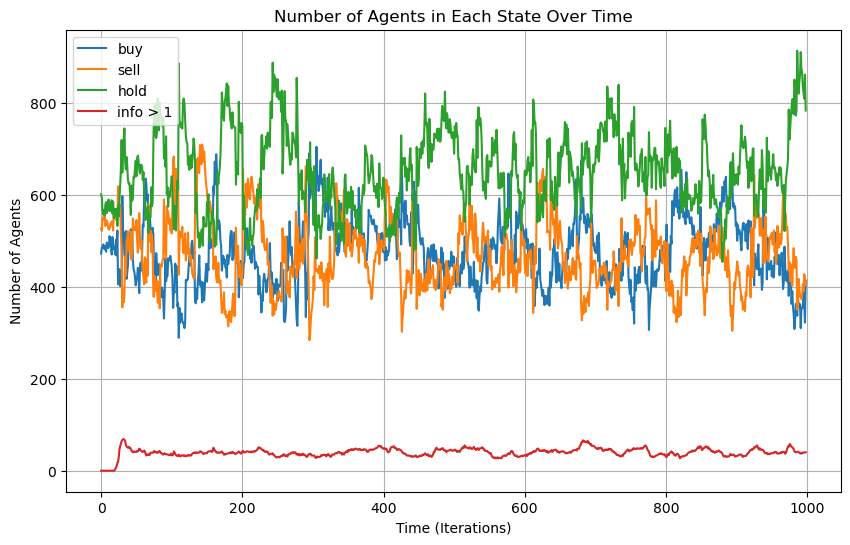

In [36]:
# Create network
network = nx.watts_strogatz_graph(N, 4, 0.02)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}
info_counts = []  # List to store the count of agents with info > 1 at each time step

actual_price = 100
ALPHA = 0.5

# Simulate market dynamics
for t in range(1, 1000):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    info_count = 0  # Counter for agents with info > 1
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))
        if agent['info'] > 1:
            info_count += 1  # Increment the counter if this agent's info > 1

        # Update expected price and actual price for each agent at each time step
        agent['expected_price'] = np.random.uniform(low=50, high=150)
        actual_price = 100
            
            
    info_counts.append(info_count)  # Add the count to the list

    for i, agent in enumerate(agents):  
        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
            
    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
    # Share decision information with neighbors only if agent's information assets exceed Ith
        if agent['info'] >= Ith:
        # Counting neighbors
            N_nn = len(neighbors)
            for neighbor in neighbors:
            # Add the agent's information to the neighbor's information assets
                agents[neighbor]['info'] += (ALPHA / N_nn) * agent['info']
            # Check if the information assets exceed the maximum value
                agents[neighbor]['info'] = min(agents[neighbor]['info'], np.finfo(float).max)

            # If the neighbor's information assets exceed the threshold, they also become active and imitate the decision
                if agents[neighbor]['info'] >= Ith:
                    agents[neighbor]['decision'] = agent['decision']
                    agent['info'] = 0
                # Neighbor also shares the decision with its neighbors
                    neighbor_neighbors = list(network.neighbors(neighbor))
                    N_nn_nn = len(neighbor_neighbors)
                    for nn in neighbor_neighbors:
                        agents[nn]['info'] += (ALPHA / N_nn_nn) * agents[neighbor]['info']
                    # Check if the information assets exceed the maximum value
                        agents[nn]['info'] = min(agents[nn]['info'], np.finfo(float).max)
                        if agents[nn]['info'] >= Ith:
                            agents[nn]['decision'] = agents[neighbor]['decision']
                            agents[neighbor]['info'] = 0       

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])
        
    
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(info_counts)), info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

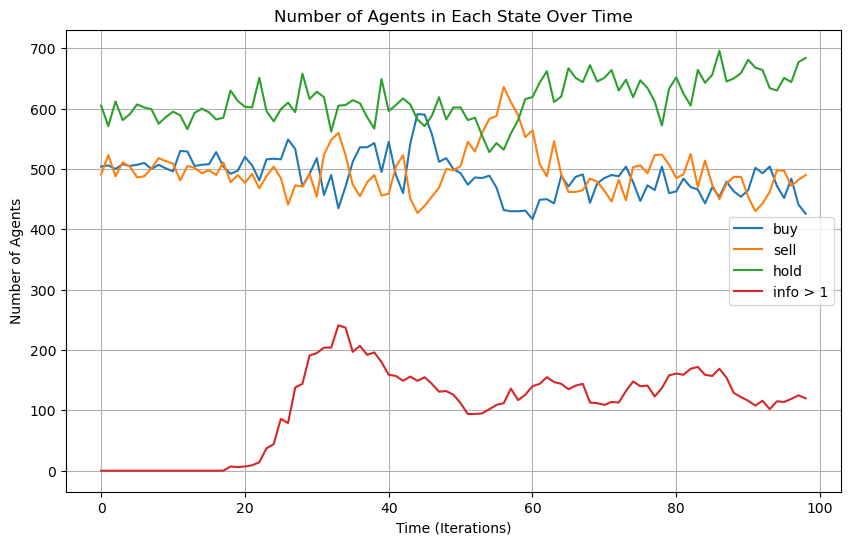

In [32]:
# Create network
network = nx.watts_strogatz_graph(N, 4, 0.02)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}
info_counts = []  # List to store the count of agents with info > 1 at each time step

actual_price = 100
ALPHA = 0.5

# Simulate market dynamics
for t in range(1, 100):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    info_count = 0  # Counter for agents with info > 1
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))
        if agent['info'] > 1:
            info_count += 1  # Increment the counter if this agent's info > 1

        # Update expected price and actual price for each agent at each time step
        agent['expected_price'] = np.random.uniform(low=50, high=150)
        actual_price = 100
            
            
    info_counts.append(info_count)  # Add the count to the list

    for i, agent in enumerate(agents):  
        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
#         else:  # 'chart'
#             # Chartist agents buy if price is increasing, sell if decreasing
#             agent['decision'] = np.random.choice(['buy', 'sell', 'hold'])

    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
        # Share decision information with neighbors only if agent's information assets exceed Ith
        if agent['info'] >= Ith:
            # Choose a random neighbor to share information with
            neighbor = np.random.choice(neighbors)
            # Add the agent's information to the neighbor's information assets
            agents[neighbor]['info'] += ALPHA * agent['info']
            # Check if the information assets exceed the maximum value
            agents[neighbor]['info'] = min(agents[neighbor]['info'], np.finfo(float).max)

            # If the neighbor's information assets exceed the threshold, they also become active and imitate the decision
            if agents[neighbor]['info'] >= Ith:
                agents[neighbor]['decision'] = agent['decision']
                # Neighbor also shares the decision with its neighbors
                neighbor_neighbors = list(network.neighbors(neighbor))
                # Choose a random neighbor to share information with
                nn = np.random.choice(neighbor_neighbors)
                agents[nn]['info'] += ALPHA * agents[neighbor]['info']
                # Check if the information assets exceed the maximum value
                agents[nn]['info'] = min(agents[nn]['info'], np.finfo(float).max)
                if agents[nn]['info'] >= Ith:
                    agents[nn]['decision'] = agents[neighbor]['decision']
            # Reset the agent's information to 0
            agent['info'] = 0

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])
        
    
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(info_counts)), info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

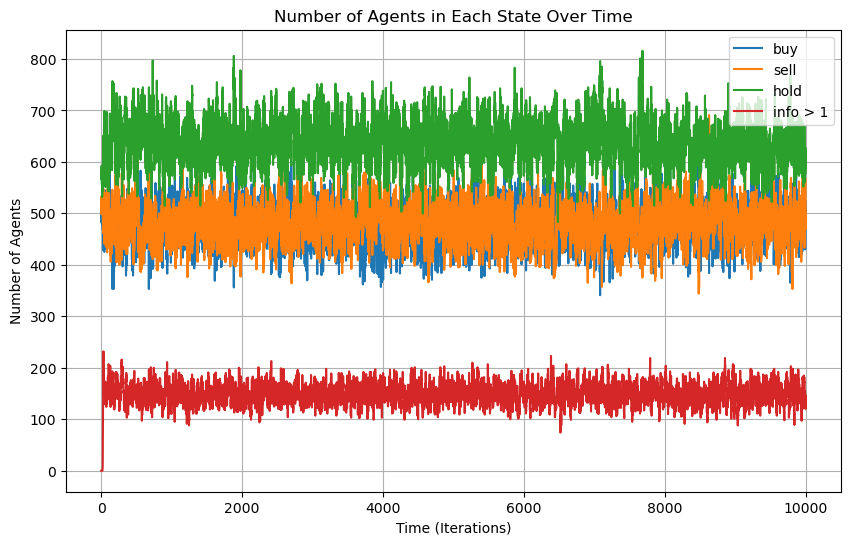

In [33]:
# Create network
network = nx.watts_strogatz_graph(N, 4, 0.02)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}
info_counts = []  # List to store the count of agents with info > 1 at each time step

actual_price = 100
ALPHA = 0.5

# Simulate market dynamics
for t in range(1, 10000):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    info_count = 0  # Counter for agents with info > 1
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))
        if agent['info'] > 1:
            info_count += 1  # Increment the counter if this agent's info > 1

        # Update expected price and actual price for each agent at each time step
        agent['expected_price'] = np.random.uniform(low=50, high=150)
        actual_price = 100
            
            
    info_counts.append(info_count)  # Add the count to the list

    for i, agent in enumerate(agents):  
        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
#         else:  # 'chart'
#             # Chartist agents buy if price is increasing, sell if decreasing
#             agent['decision'] = np.random.choice(['buy', 'sell', 'hold'])

    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        neighbors = list(network.neighbors(i))
        # Share decision information with neighbors only if agent's information assets exceed Ith
        if agent['info'] >= Ith:
            # Choose a random neighbor to share information with
            neighbor = np.random.choice(neighbors)
            # Add the agent's information to the neighbor's information assets
            agents[neighbor]['info'] += ALPHA * agent['info']
            # Check if the information assets exceed the maximum value
            agents[neighbor]['info'] = min(agents[neighbor]['info'], np.finfo(float).max)

            # If the neighbor's information assets exceed the threshold, they also become active and imitate the decision
            if agents[neighbor]['info'] >= Ith:
                agents[neighbor]['decision'] = agent['decision']
                # Neighbor also shares the decision with its neighbors
                neighbor_neighbors = list(network.neighbors(neighbor))
                # Choose a random neighbor to share information with
                nn = np.random.choice(neighbor_neighbors)
                agents[nn]['info'] += ALPHA * agents[neighbor]['info']
                # Check if the information assets exceed the maximum value
                agents[nn]['info'] = min(agents[nn]['info'], np.finfo(float).max)
                if agents[nn]['info'] >= Ith:
                    agents[nn]['decision'] = agents[neighbor]['decision']
            # Reset the agent's information to 0
            agent['info'] = 0

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])
        
    
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(info_counts)), info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()

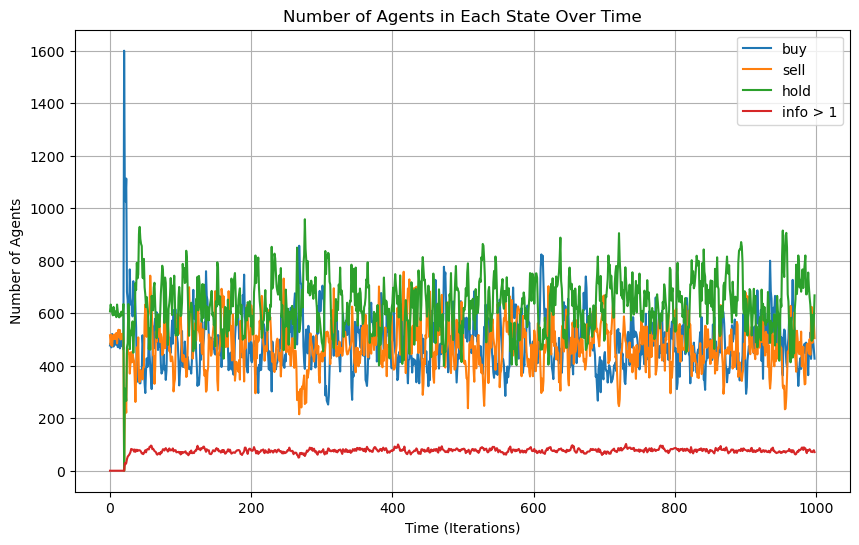

In [39]:
# Create network
network = nx.watts_strogatz_graph(N, 4, 0.02)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}
info_counts = []  # List to store the count of agents with info > 1 at each time step

actual_price = 100
ALPHA = 0.5


def propagate_info(agent_index, agents, network, ALPHA, Ith):
    agent = agents[agent_index]
    neighbors = list(network.neighbors(agent_index))
    if agent['info'] >= Ith:
        N_nn = len(neighbors)
        for neighbor in neighbors:
            agents[neighbor]['info'] += (ALPHA / N_nn) * agent['info']
            agents[neighbor]['info'] = min(agents[neighbor]['info'], np.finfo(float).max)
            if agents[neighbor]['info'] >= Ith:
                agents[neighbor]['decision'] = agent['decision']
                agent['info'] = 0
                propagate_info(neighbor, agents, network, ALPHA, Ith)  # Recursive call

# Simulate market dynamics
for t in range(1, 1000):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    info_count = 0  # Counter for agents with info > 1
    for i, agent in enumerate(agents):
        # Increase information assets
        agent['info'] += np.random.uniform(0, Ith - max(agent['info'], 0))
        if agent['info'] > 1:
            info_count += 1  # Increment the counter if this agent's info > 1

        # Update expected price and actual price for each agent at each time step
        agent['expected_price'] = np.random.uniform(low=50, high=150)
        actual_price = 100
            
            
    info_counts.append(info_count)  # Add the count to the list

    for i, agent in enumerate(agents):  
        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
            
    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        propagate_info(i, agents, network, ALPHA, Ith)

    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])
        
    
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
for state, counts in state_counts.items():
    plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(info_counts)), info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()